In [ ]:
import zipfile
import os

# Define the path to the uploaded file
zip_file = 'resized.zip'  # Replace this with the actual filename

# Unzip the folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# List the contents to verify
os.listdir()

['.config', 'resized', 'resized.zip', 'sample_data']

In [ ]:
!sed -i 's/from keras.engine.topology import get_source_inputs/from keras.utils.layer_utils import get_source_inputs/g' /usr/local/lib/python3.10/dist-packages/keras_vggface/models.py




Epoch 1/10
4/4 [==============================] - 50s 14s/step - loss: 4.9462 - accuracy: 0.6261 - val_loss: 1.4922 - val_accuracy: 0.6562
Epoch 2/10
4/4 [==============================] - 55s 12s/step - loss: 4.3389 - accuracy: 0.7043 - val_loss: 1.4042 - val_accuracy: 0.5938
Epoch 3/10
4/4 [==============================] - 48s 14s/step - loss: 3.8682 - accuracy: 0.7217 - val_loss: 1.2798 - val_accuracy: 0.6250
Epoch 4/10
4/4 [==============================] - 53s 14s/step - loss: 3.3036 - accuracy: 0.7031 - val_loss: 1.1712 - val_accuracy: 0.6562
Epoch 5/10
4/4 [==============================] - 53s 14s/step - loss: 2.9095 - accuracy: 0.7266 - val_loss: 1.2921 - val_accuracy: 0.5625
Epoch 6/10
4/4 [==============================] - 48s 12s/step - loss: 2.4199 - accuracy: 0.7043 - val_loss: 1.1168 - val_accuracy: 0.6562
Epoch 7/10
4/4 [==============================] - 49s 14s/step - loss: 2.5043 - accuracy: 0.6957 - val_loss: 1.1294 - val_accuracy: 0.6562
Epoch 8/10
4/4 [===========

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

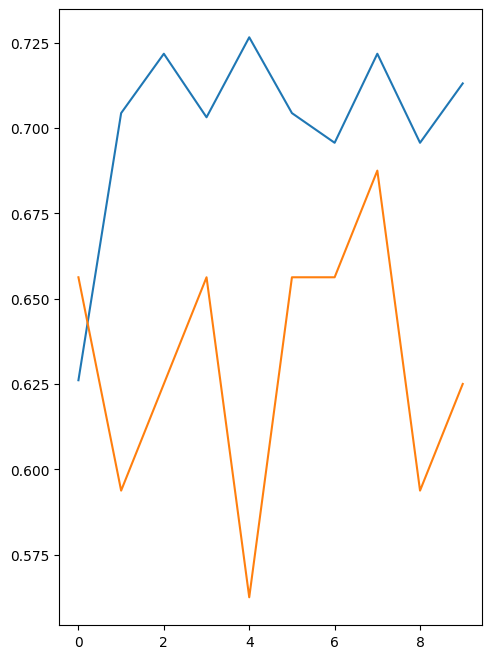

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, utils
from sklearn.utils import class_weight

# Set paths for your dataset
data_dir = r'/content/resized'  # Change this to your dataset path
img_size = (224, 224)

# Create ImageDataGenerator instances for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def load_data(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)  # Assuming each subfolder is a class
    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_names.index(label))
    return np.array(images), np.array(labels)

# Load dataset
X, y = load_data(data_dir)

# Split the dataset into training and validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)  # Assuming 5 classes
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)

# Create flow generators for training and validation

# Create generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
# Create flow generators for training and validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Assuming you have your class indices for train data
class_labels = [0] * 112 + [1] * 10 + [2] * 20 + [3] * 15 + [4] * 10 + [5] * 15 # Example

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

# Convert to dictionary
class_weight_dict = {i: weights[i] for i in range(len(weights))}

# Load VGG-Face model without the top classification layer
base_model = VGGFace(include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(6, activation='softmax')  # Change this number to match your number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // train_generator.batch_size,  # Use len(X_train)
    validation_data=val_generator,
    validation_steps=len(X_val) // val_generator.batch_size,  # Use len(X_val)
    epochs=10,
    class_weight=class_weight_dict
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // train_generator.batch_size,  # Use len(X_train)
    validation_data=val_generator,
    validation_steps=len(X_val) // val_generator.batch_size,  # Use len(X_val)
    epochs=5  # Fine-tuning for a few epochs
)

# Plot training & validation accuracy and loss
def plot_history(history, fine_tune_history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    fine_acc = fine_tune_history.history['accuracy']
    fine_val_acc = fine_tune_history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fine_loss = fine_tune_history.history['loss']
    fine_val_loss = fine_tune_history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy (Initial)')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy (Initial)')
    plt.plot(epochs_range, fine_acc, label='Training Accuracy (Fine-tuned)', linestyle='--')
    plt.plot(epochs_range, fine_val_acc, label='Validation Accuracy (Fine-tuned)', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss (Initial)')
    plt.plot(epochs_range, val_loss, label='Validation Loss (Initial)')
    plt.plot(epochs_range, fine_loss, label='Training Loss (Fine-tuned)', linestyle='--')
    plt.plot(epochs_range, fine_val_loss, label='Validation Loss (Fine-tuned)', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot the training and fine-tuning history
plot_history(history, fine_tune_history)


In [ ]:
# Save the model to a file
model.save('/content/facemudra.keras')  # Change the path and filename as needed
